In [1]:
%matplotlib inline

# from pathlib import Path

import numpy as np
import pandas as pd
import pandas_datareader.data as web
from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow import keras

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Fix the path construction - use forward slashes or raw strings
import os

In [2]:

# Method 1: Use forward slashes (recommended)
path = os.path.abspath(os.path.join("..", "04_S&P500_quant_analysis", "01_data", "S&P500_D_1789-05-01_2025-09-17.csv"))

# Alternative Method 2: Use raw string
# path = os.path.abspath(os.path.join("..", r"04_S&P500_quant_analysis\01_data", "S&P500_D_1789-05-01_2025-09-17.csv"))

# Alternative Method 3: Use pathlib (modern approach)
# from pathlib import Path
# path = Path("..") / "04_S&P500_quant_analysis" / "01_data" / "S&P500_D_1789-05-01_2025-09-17.csv"

print(f"Path exists: {os.path.exists(path)}")

# Read the CSV file
df = pd.read_csv(path)

# lower case column names for easier access
df.columns = [col.lower() for col in df.columns]

# Set the 'date' column as the index and convert it to datetime
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# filter years from 1960
df = df[df.index.year >= 1960]

# Show the first few rows of the dataframe
df.head()

Path exists: True


,open,high,low,close,volume
date,,,,,
1960-01-04,59.91,59.91,59.91,59.91,2216667.0
1960-01-05,60.39,60.39,60.39,60.39,2061111.0
1960-01-06,60.13,60.13,60.13,60.13,2072222.0
1960-01-07,59.69,59.69,59.69,59.69,1838889.0
1960-01-08,59.50,59.50,59.50,59.50,1827778.0


In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [4]:
sns.set_style('whitegrid')
np.random.seed(42)

In [5]:
# results_path = Path('results', 'univariate_time_series')
# if not results_path.exists():
#     results_path.mkdir(parents=True)

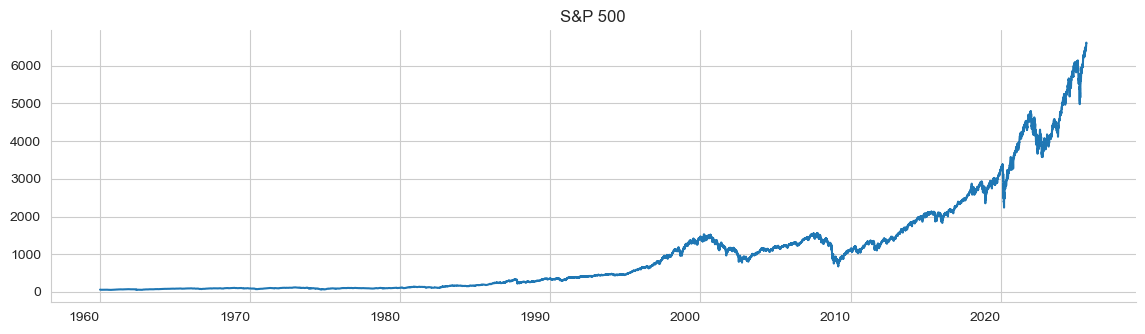

In [6]:
sp500 = df.close.copy()
ax = sp500.plot(title='S&P 500',
           legend=False,
           figsize=(14, 4),
           rot=0)
ax.set_xlabel('')
sns.despine()

In [7]:
scaler = MinMaxScaler()
sp500_scaled = pd.Series(scaler.fit_transform(sp500.values.reshape(-1, 1)).squeeze(), 
                         index=sp500.index)
sp500_scaled.describe()

"""
sp500.values.reshape(-1, 1) converts the Series to a 2D numpy array 
with shape (n_samples, 1)
-1 means "infer the dimension" and 1 means "1 feature column"
.squeeze() converts the 2D result back to 1D for creating the Series
"""

# # Alternative approach
# scaler = MinMaxScaler()
# sp500_scaled = pd.Series(scaler.fit_transform(sp500.to_frame()).squeeze(), 
#                          index=sp500.index)
# sp500_scaled.describe()

'\nsp500.values.reshape(-1, 1) converts the Series to a 2D numpy array \nwith shape (n_samples, 1)\n-1 means "infer the dimension" and 1 means "1 feature column"\n.squeeze() converts the 2D result back to 1D for creating the Series\n'

In [8]:
def create_univariate_rnn_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

In [9]:
"""
X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
This line of code creates a feature matrix X for time series analysis 
using a sliding window approach. 

The core operation uses np.hstack() to horizontally stack multiple arrays together, 
combining them column-wise into a single matrix. 
The arrays being stacked are generated by a list comprehension that creates 
time-lagged versions of the original data.

The list comprehension [data[i: n-j, :] 
for i, j in enumerate(range(window_size, 0, -1))] 
is the heart of this operation. 
It uses enumerate() on a reversed range to create multiple slices of the data array. 
The range(window_size, 0, -1) generates numbers counting down from window_size to 1, 
which determines how many time steps back to look for each feature.

For each iteration, i represents the current index (starting from 0), 
and j represents the countdown value from the range. 
The slicing data[i: n-j, :] extracts a portion of the data starting 
from row i and ending at row n-j, where n is likely the total number 
of time steps. This creates overlapping windows of historical data, 
with each subsequent slice shifted by one time step.

The resulting slices are different lengths due to the varying start and end points, 
but they represent consecutive time windows of the data. 
When these slices are horizontally stacked using np.hstack(), 
they form a feature matrix where each row represents a time point, 
and the columns contain the current value plus lagged values 
from previous time steps. 
This is a common technique in time series regression where 
you want to use historical values as predictive features 
for forecasting future values.

The tuple() wrapper around the list comprehension is required because 
np.hstack() expects a sequence of arrays, 
and converting the list to a tuple ensures compatibility 
with the function's expected input format.
""";

In [10]:
window_size = 63
X, y = create_univariate_rnn_data(sp500_scaled, window_size=window_size)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
date,,,,,,,,,,,,,,,,,,,,,
1960-04-01,0.001175,0.001248,0.001208,0.001141,0.001112,0.001001,0.000946,0.000896,0.000945,0.000942,...,0.000428,0.000437,0.000471,0.000539,0.000576,0.000576,0.000558,0.000545,0.000527,0.000478
1960-04-04,0.001248,0.001208,0.001141,0.001112,0.001001,0.000946,0.000896,0.000945,0.000942,0.000867,...,0.000437,0.000471,0.000539,0.000576,0.000576,0.000558,0.000545,0.000527,0.000478,0.000492
1960-04-05,0.001208,0.001141,0.001112,0.001001,0.000946,0.000896,0.000945,0.000942,0.000867,0.000773,...,0.000471,0.000539,0.000576,0.000576,0.000558,0.000545,0.000527,0.000478,0.000492,0.000509
1960-04-06,0.001141,0.001112,0.001001,0.000946,0.000896,0.000945,0.000942,0.000867,0.000773,0.000742,...,0.000539,0.000576,0.000576,0.000558,0.000545,0.000527,0.000478,0.000492,0.000509,0.000483
1960-04-07,0.001112,0.001001,0.000946,0.000896,0.000945,0.000942,0.000867,0.000773,0.000742,0.000763,...,0.000576,0.000576,0.000558,0.000545,0.000527,0.000478,0.000492,0.000509,0.000483,0.000657


In [11]:
y.head()

date
1960-04-01    0.000492
1960-04-04    0.000509
1960-04-05    0.000483
1960-04-06    0.000657
1960-04-07    0.000658
dtype: float64

In [12]:
X.shape

(16474, 63)

In [13]:
y.shape

(16474,)

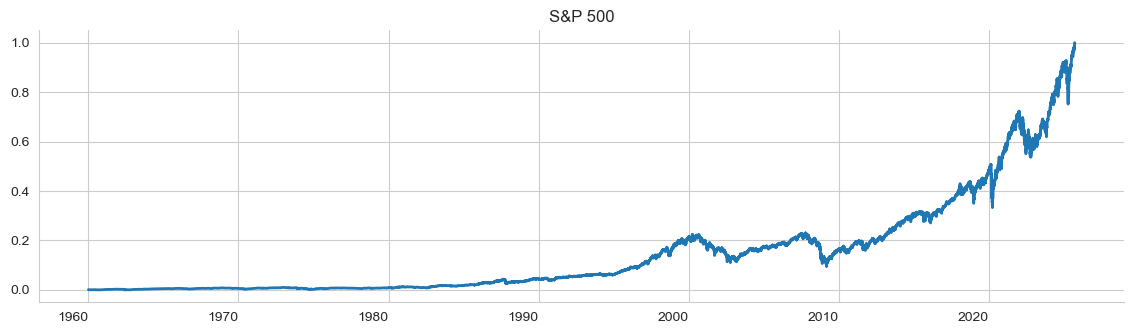

In [14]:
ax = sp500_scaled.plot(title='S&P 500',
           legend=False, 
           lw=2, 
           figsize=(14, 4), 
           rot=0)
ax.set_xlabel('')
sns.despine()

In [15]:
X_train = X[:'2020'].values.reshape(-1, window_size, 1)
y_train = y[:'2020']

# keep the last year for testing
X_test = X['2021'].values.reshape(-1, window_size, 1)
y_test = y['2021']

n_obs, window_size, n_features = X_train.shape

y_train.shape

(15292,)

In [16]:
rnn = Sequential([
    LSTM(units=10, 
         input_shape=(window_size, n_features), name='LSTM'),
    Dense(1, name='Output')
])


rnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM (LSTM)                     │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491 (1.92 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# complete ...